In [1]:
# Import necessary libraries
from fastai.vision.all import *
import pandas as pd
from pathlib import Path # Ensure Path is imported

In [2]:
# --- Steps 1-3: Read CSV, define existence check, filter DataFrame (as before) ---
path = Path('data/')
try:
    df = pd.read_csv(path / 'styles.csv', on_bad_lines='skip') 
except FileNotFoundError: 
    print("styles.csv not found, trying metadata.csv...")
    try:
        df = pd.read_csv(path / 'metadata.csv', on_bad_lines='skip') 
    except FileNotFoundError:
        print("Error: Neither styles.csv nor metadata.csv found.")
        df = pd.DataFrame() 

def image_file_exists(row):
    image_path = path / 'images' / f"{row['id']}.jpg" 
    return image_path.is_file() 

print(f"Original number of rows: {len(df)}")
df_filtered = df[df.apply(image_file_exists, axis=1)].copy()
print(f"Number of rows after filtering: {len(df_filtered)}")


Original number of rows: 44424
Number of rows after filtering: 44419


In [3]:
path.ls()

(#2) [Path('data/images'),Path('data/styles.csv')]

In [4]:
path.ls()

(#2) [Path('data/images'),Path('data/styles.csv')]

In [5]:
df = pd.read_csv('data/styles.csv',on_bad_lines='skip')
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [7]:
# --- Step 3.5: SUBSET the DataFrame ---
num_items_to_load = 10000 
if len(df_filtered) > num_items_to_load:
    # Option 1: Take the first N items
    df_subset = df_filtered.iloc[:num_items_to_load]
    
    # Option 2: Take a random sample of N items (uncomment if preferred)
    # df_subset = df_filtered.sample(n=num_items_to_load, random_state=42) 
    
    print(f"Using a subset of {len(df_subset)} items.")
else:
    df_subset = df_filtered # Use all data if less than N
    print(f"Using all available {len(df_subset)} items (less than requested subset size).")

Using a subset of 10000 items.


In [8]:
# --- Step 4: Recreate DataLoaders with the SUBSET DataFrame ---
# (DataBlock definition and helper functions remain the same)
def get_x(row):
    return path / 'images' / f"{row['id']}.jpg" 
def get_y(row):
    attribute_columns = ['gender', 'masterCategory', 'subCategory', 
                           'articleType', 'baseColour', 'season', 'usage']
    return [str(row[col]) for col in attribute_columns]

In [9]:
get_x(df_filtered.iloc[2,:])

Path('data/images/59263.jpg')

In [10]:
get_y(df_filtered.iloc[2,:])

['Women', 'Accessories', 'Watches', 'Watches', 'Silver', 'Winter', 'Casual']

In [11]:
# --- Create Vocabulary from the SUBSET DataFrame FIRST ---
print("Creating vocabulary from the subset...")
# Apply the get_y function to the entire subset to get all possible labels
all_labels = df_subset.apply(get_y, axis=1).explode().unique().tolist()
print(f"Found {len(all_labels)} unique labels.")

Creating vocabulary from the subset...
Found 219 unique labels.


In [12]:
# --- Define the DataBlock, passing the explicit vocabulary ---
clothing_block = DataBlock(
    # Pass the created vocabulary to MultiCategoryBlock
    blocks=(ImageBlock, MultiCategoryBlock(vocab=all_labels)), 
    get_x=get_x,                             
    get_y=get_y,                             
    splitter=RandomSplitter(valid_pct=0.2, seed=42), 
    item_tfms=Resize(460),                   
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), 
                Normalize.from_stats(*imagenet_stats)] 
)

In [13]:
# --- Step 5: Create DataLoaders ---
# IMPORTANT: Use df_subset here!
print("\nCreating DataLoaders with the subset data and explicit vocab...")
dls = clothing_block.dataloaders(df_subset, bs=32) # Or bs=8, bs=4
print("DataLoaders created successfully.")


Creating DataLoaders with the subset data and explicit vocab...
DataLoaders created successfully.



Showing a sample batch from the subset:


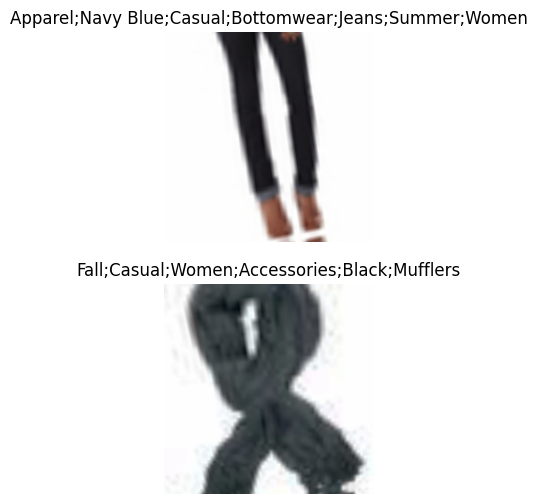

In [14]:
# --- Step 6: Verify again ---
print("\nShowing a sample batch from the subset:")
dls.show_batch(nrows=2, ncols=1, max_n=2)

In [15]:

# --- Step 7: Train the model (as before) ---
learn = vision_learner(dls, resnet34, metrics=accuracy_multi) 

Finding suggested learning rate...


SuggestedLRs(valley=0.002511886414140463)

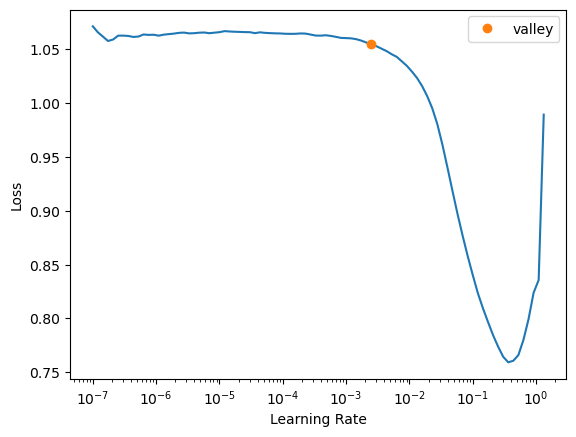

In [ ]:
# Find the best learning rate
print("Finding suggested learning rate...")
learn.lr_find()

In [16]:
chosen_lr = 3e-2 # Or your chosen LR
print(f"\nStarting training with learning rate: {chosen_lr}")
learn.fine_tune(4, base_lr=chosen_lr)


Starting training with learning rate: 0.03


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.072699,0.044947,0.984342,1:13:03


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.046671,0.040997,0.985333,19:32
1,0.041144,0.034796,0.987470,19:33
2,0.034458,0.030174,0.988874,19:26
3,0.029796,0.028012,0.989827,28:05


# Find Threshold

Getting predictions on validation set...


Finding optimal threshold...

Best threshold: 0.4550
Accuracy at best threshold: TensorBase(0.9899)


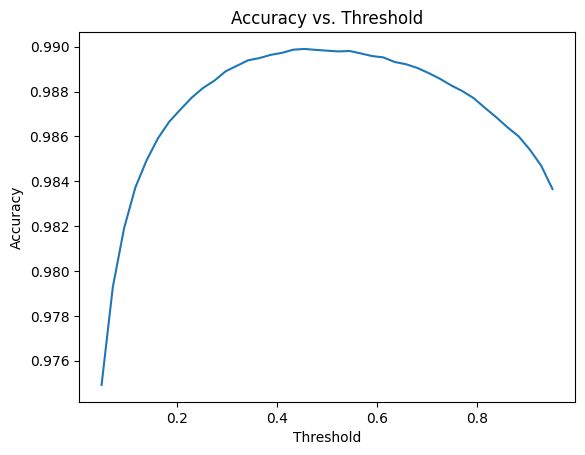

In [18]:
# 1. Get predictions on the validation set
print("Getting predictions on validation set...")
preds, targs = learn.get_preds()

# 2. Test different thresholds and find the best one
print("Finding optimal threshold...")
xs = torch.linspace(0.05, 0.95, 41) # Test 41 thresholds between 0.05 and 0.95
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs] # sigmoid=False because get_preds already applies it

# 3. Plot the results
plt.plot(xs, accs);
plt.title("Accuracy vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")

# 4. Find and print the best threshold and accuracy
best_thresh_idx = torch.tensor(accs).argmax()
best_thresh = xs[best_thresh_idx]
best_acc = accs[best_thresh_idx]
print(f"\nBest threshold: {best_thresh:.4f}")
print(f"Accuracy at best threshold: {best_acc:}")

# Test Time Augmentation (TTA)

In [21]:
# Evaluate the model using Test Time Augmentation
# It will use the validation set by default
print("Evaluating with Test Time Augmentation (TTA)...")
preds_tta, targs_tta = learn.tta()

# Calculate accuracy using the BEST threshold we found
best_thresh = 0.45 # Use the value you found from the plot
acc_tta = accuracy_multi(preds_tta, targs_tta, thresh=best_thresh, sigmoid=False) 

print(f"\nAccuracy with TTA (using threshold {best_thresh}): {acc_tta}")

# You can also check accuracy with the default threshold (0.5) for comparison
acc_tta_default = accuracy_multi(preds_tta, targs_tta, thresh=0.5, sigmoid=False)
print(f"Accuracy with TTA (using default threshold 0.5): {acc_tta_default}")

Evaluating with Test Time Augmentation (TTA)...



Accuracy with TTA (using threshold 0.45): TensorBase(0.9900)
Accuracy with TTA (using default threshold 0.5): TensorBase(0.9900)


# Progressive Resizing

In [22]:
# --- Stage 1: Train with smaller images (e.g., 128x128) ---
print("--- Stage 1: Training with small images (128x128) ---")

# Create DataLoaders with small size
dls_small = clothing_block.dataloaders(df_subset, bs=32, # Use a slightly larger bs if possible
                                         item_tfms=Resize(240), # Resize slightly larger than final
                                         batch_tfms=[*aug_transforms(size=128, min_scale=0.75),
                                                     Normalize.from_stats(*imagenet_stats)])

# Create a NEW Learner for this stage
learn_prog = vision_learner(dls_small, resnet34, metrics=accuracy_multi)

# Train for a few epochs
learn_prog.fit_one_cycle(4, 3e-2) # Use an appropriate LR, maybe find it again for small size

# --- Stage 2: Fine-tune with larger images (224x224) ---
print("\n--- Stage 2: Fine-tuning with larger images (224x224) ---")

# Create DataLoaders with the original (larger) size
dls_large = clothing_block.dataloaders(df_subset, bs=16) # Back to smaller bs for larger images

# Replace the DataLoaders in the existing Learner
learn_prog.dls = dls_large

# Fine-tune the learner
learn_prog.fine_tune(4, base_lr=3e-2) # Use a smaller base_lr for fine-tuning

# --- (Optional) Evaluate with best threshold and TTA ---
# preds, targs = learn_prog.get_preds()
# xs = torch.linspace(0.05, 0.95, 41)
# accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
# best_thresh_prog = xs[torch.tensor(accs).argmax()]
# print(f"\nBest threshold after progressive resizing: {best_thresh_prog:.4f}")
# preds_tta, targs_tta = learn_prog.tta()
# acc_tta_prog = accuracy_multi(preds_tta, targs_tta, thresh=best_thresh_prog, sigmoid=False)
# print(f"Final accuracy with Progressive Resizing + TTA: {acc_tta_prog:.4f}")

--- Stage 1: Training with small images (128x128) ---


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.072966,0.048290,0.983171,23:22
1,0.046734,0.040096,0.985308,23:18
2,0.040435,0.034919,0.987185,22:06
3,0.035036,0.030363,0.988874,22:02



--- Stage 2: Fine-tuning with larger images (224x224) ---


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.050708,0.039769,0.986068,20:55


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.049495,0.044651,0.983929,21:05
1,0.044778,0.036268,0.986895,31:07
2,0.037607,0.030806,0.988762,32:22
3,0.032846,0.029302,0.989235,32:34


# Mixup

In [31]:
from fastai.vision.all import *
from fastai.callback.mixup import MixUp

In [32]:
# --- Training with Mixup ---
print("\n--- Training with Mixup ---")
# Use the original large DataLoaders
dls = clothing_block.dataloaders(df_subset, bs=16) 


# Create a NEW Learner with the Mixup callback
learn_mixup = vision_learner(dls, resnet34, metrics=accuracy_multi,
                             cbs=MixUp) # Add Mixup here

# Find learning rate again (Mixup can change the loss landscape)
# learn_mixup.lr_find() 
# chosen_lr_mixup = ?? # Choose LR from plot

# Train for MORE epochs (Mixup needs more time)
learn_mixup.fit_one_cycle(8, 3e-2) # Example: 8 epochs, adjust LR

# --- (Optional) Evaluate with best threshold and TTA ---
# preds, targs = learn_mixup.get_preds()
# ... (find best threshold as before) ...
# preds_tta, targs_tta = learn_mixup.tta()
# ... (calculate final accuracy as before) ...


--- Training with Mixup ---


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.075051,0.050033,0.983036,17:56
1,0.069955,0.056686,0.980653,28:05
2,0.067096,0.050711,0.982333,27:08
3,0.064462,0.045175,0.983786,28:08
4,0.059079,0.039572,0.985642,28:56
5,0.056162,0.036955,0.986790,5:47:56
6,0.053012,0.034548,0.987603,21:19
7,0.052439,0.034589,0.987425,20:30
